In [1]:
# Notes:
# матрица симметричная, не забывать, что может быть двойное включение
# loss function modifyable
# extract_good_regions - может быть другая
# квадраты, которые мы не выбрали для validation set'а

# Когда TASK_SIZE становится больше ~300, plt.imshow() начинает показывать не все nan - участки
# Из-за этого кажется, что выбор хороших квадратов работает неправильно и выбирает хороший квадрат "не до конца"
# Можно приблизить конкретный участок и убедиться, что там на самом деле есть маленький квадрат, окруженный nan'ами

# по диагонали берутся данные дважды - обычные и зеркальные
# если берем квадрат из одного из треугольников, надо брать такой же квадарт в другом из треугольников
# квадраты ориентированы по разному. сверху до низу может быть градиент, другой квадрат может помочь нарушить эту зависимость
# -1 дважды

# фича - насколько далеко от диагонали находится квадратик
# фичи - диагональный крест
# Поговорить с Лемпицким - посмотреть его сетку

# TODO:
# 1) Выбирать квадрат из другого треугольника, если он был выбран в одном из треугольников

# Plans:
# 1) Important: We should try to normalize whole matrix (X and Y), then we should denormalize results +
# 2) Train on more data
# 3) Try different features
# 4) Add more layers
# 5) Scatter plot?
# 6) Offset in matrix prediction - bug?
# 7) Try to change cost function. Maybe MSE is not enough?
# 8) попробовать брать значения только из одного треугольника

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py
import random

import math
import tensorflow as tf
from tensorflow.python.framework import ops

import cooler

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# the following directive activates inline plotting
%matplotlib inline

# allow to allocate resources for model training
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [4]:
# constants
TASK_SIZE = 100

# TODO: вынести в константы все остальные параметры (defect thresh, number of coin tosses, sigma
# + константы, относящиеся к нейронной сети)

In [5]:
def plot_hic(matrix):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.matshow(np.log10(matrix), cmap='YlOrRd')
    fig.colorbar(im)

In [6]:
def mark_nans_as_zeros(matrix):
    # we think NaN == 0 for now
    matrix[np.isnan(matrix)] = 0

In [7]:
def mark_defective_as_nan(matrix):
    # row or column is considered to be defective if less than 5% of values are non-zero
    # Since we work with the small and relatively good region of the entire Hi-C map, threshold is set to 20%
    # Don't forget to set back to 5% when working with the entire map, because leaving 20% clears all the map
    DEFECT_THRESHOLD = 20
    
    # non-zero values will give True
    boolean_matrix = matrix != 0
    
    defective_rows = np.where(np.sum(boolean_matrix, axis = 1) < ((TASK_SIZE / 100) * DEFECT_THRESHOLD))
    defective_columns = np.where(np.sum(boolean_matrix, axis = 0) < ((TASK_SIZE / 100) * DEFECT_THRESHOLD))
    
    # place nan value for all defective rows
    for defective_row in defective_rows:
        matrix[defective_row, :] = np.nan
        
    for defective_column in defective_columns:
        matrix[:, defective_column] = np.nan
        

In [8]:
# function drops a coin pseudo randomly somewhere on the hi-c map 
# to select the region that will get into the training set
# The coin is not fair, it extracts regions near the diagonal more frequently
def _coin_toss():
    # sigma is a tunable parameter
    # sigma is smaller => selected segments are closer to the diagonal
    sigma = int(TASK_SIZE/10)

    result = []
    for coordinate in np.random.normal(random.randint(sigma, TASK_SIZE - sigma), sigma, 2):
        if coordinate < TASK_SIZE:
            if coordinate >= 0:
                result.append(int(coordinate))
            else:
                result.append(0)
        else:
            result.append(TASK_SIZE - 1)
    
    return result

In [9]:
def _search_edges(extraction_matrix, coin_xy):
    upper_left = [coin_xy[0], coin_xy[1]]
    
    while upper_left[0] - 1 >= 0 and extraction_matrix[upper_left[0] - 1][upper_left[1]] == 0: 
        upper_left[0] -= 1
    
    while upper_left[1] - 1 >= 0 and extraction_matrix[upper_left[0]][upper_left[1] - 1] == 0:
        upper_left[1] -= 1
                                                       
    lower_right = [coin_xy[0], coin_xy[1]]
    
    while lower_right[0] + 1 < TASK_SIZE and extraction_matrix[lower_right[0] + 1][lower_right[1]] == 0:
        lower_right[0] += 1
    
    while lower_right[1] + 1 < TASK_SIZE and extraction_matrix[lower_right[0]][lower_right[1] + 1] == 0:
        lower_right[1] += 1
        
    return upper_left, lower_right
                                        

In [92]:
def extract_good_regions(matrix):
    # TODO: this value is hardcoded for now, but it should be computed dynamically
    # This number will depend on: number of good regions, good region to bad region ratio (good region density),
    # map size (?), tunable parameter C (human can tune this parameter looking at the visualization)
    # The number of good regions can be estimated by the number of defect intersections
    number_of_tosses = 30
    extraction_matrix = np.isnan(matrix).astype(int)
    resulting_matrices = []
    
    for i in range(number_of_tosses):
        x_y = _coin_toss()
        
        if extraction_matrix[x_y[0]][x_y[1]] == 0:
            upper_left, lower_right = _search_edges(extraction_matrix, x_y)
            resulting_matrices.append(matrix[upper_left[0]:(lower_right[0] + 1), upper_left[1]:(lower_right[1] + 1)])
        
            # -1 where extraction happened
            extraction_matrix[upper_left[0]:(lower_right[0] + 1), upper_left[1]:(lower_right[1] + 1)] = -1
            
    return resulting_matrices, extraction_matrix

In [93]:
# import hi-c data (drosophila embryo)
filepath = "Kc167.10000.cool"
c = cooler.Cooler(filepath)

# TODO (future): train на одной хромосоме, test на другой хромосоме
# получаем карту контактов для одной хромосомы, нам не нужны межхромосомные взаимодействия
arr = c.matrix().fetch("chr2L")

current_matrix = arr[0:TASK_SIZE, 0:TASK_SIZE]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


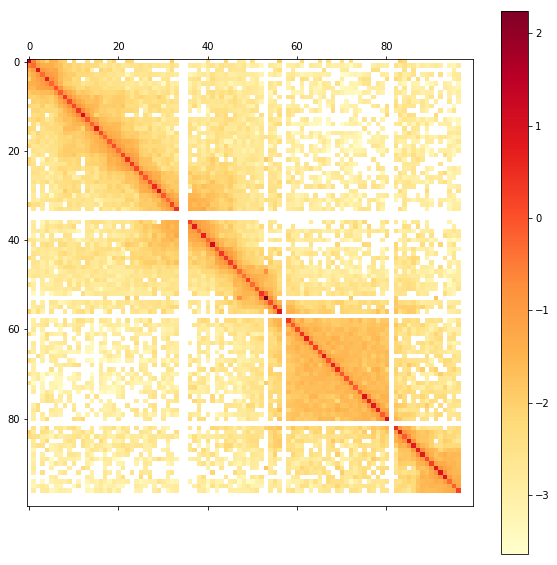

In [94]:
# plots before data cleaning
plot_hic(current_matrix)

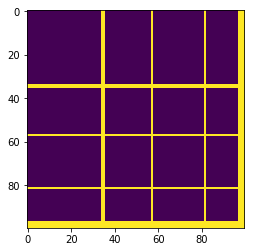

In [95]:
plt.imshow(np.isnan(current_matrix))

In [96]:
# clean the data
mark_nans_as_zeros(current_matrix)
mark_defective_as_nan(current_matrix)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


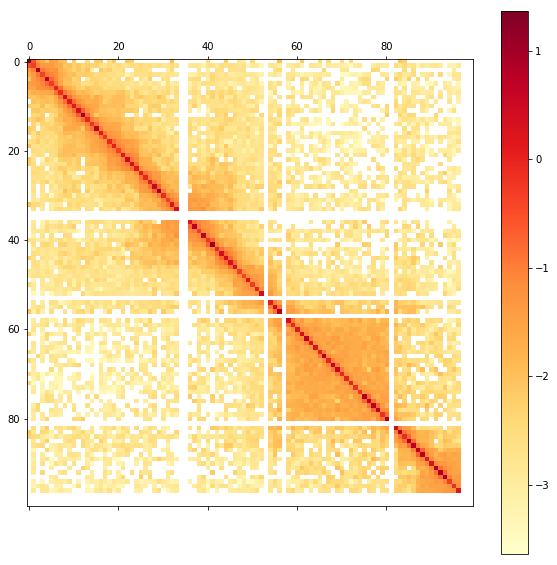

In [97]:
# plots after data cleaning
plot_hic(current_matrix)

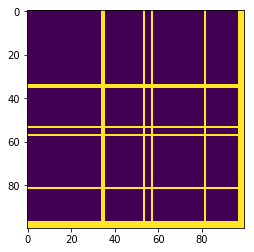

In [98]:
plt.imshow(np.isnan(current_matrix))

In [99]:
# разброс между значениями в матрице очень большой (0...20)
# из-за этого нейронная сеть не учится распознавать разницу меджу маленькими значениями
# поэтому мы нормализуем матрицу чтобы привести все значения в диапазон 0...1
def normalize(matrix):
    matrix_max = np.nanmax(matrix)
    matrix_min = np.nanmin(matrix)
    
    return (matrix - matrix_min) / (matrix_max - matrix_min), matrix_max, matrix_min

def denormalize(matrix, old_max, old_min):
    return matrix * (old_max - old_min) + old_min

normalized_matrix, old_max, old_min = normalize(current_matrix)

In [124]:
resulting_matrices, visualization_matrix = extract_good_regions(normalized_matrix)

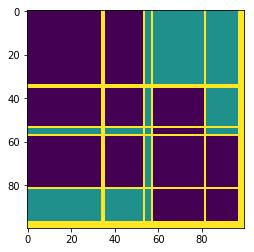

In [125]:
plt.imshow(visualization_matrix)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


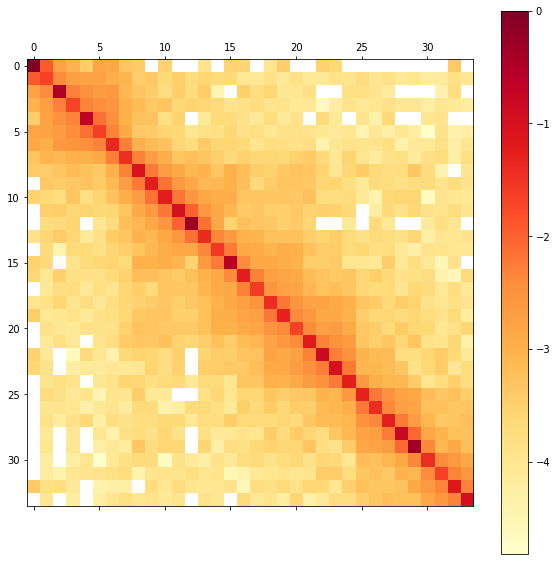

In [126]:
plot_hic(resulting_matrices[0])

In [127]:
# forms train and test subsets from one submatrix
# Version 1: Only upper and lower cells are considered
# TODO: Square feature selection
def form_train_subset_v1(matrix):
    # this is a tunable parameter
    # could be 4 or much more
    # only 2 neighboring cells for training for now
    number_of_features = 2
    
    # the submatrix is too small to form training set
    if matrix.shape[0] < (number_of_features + 1):
        return (None, None)
    
    cut_indices = np.arange((number_of_features + 1), matrix.shape[0], step = (number_of_features + 1))
    
    submatrices = np.split(matrix, cut_indices)
    
    # first train_x and train_y (outside of the loop)
    train_x = np.delete(submatrices[0], (number_of_features // 2), axis = 0)
    train_y = submatrices[0][(number_of_features // 2), :]
    
    for submatrice in submatrices[1:]:
        # if clause to avoid the last not full chunk
        if submatrice.shape[0] == (number_of_features + 1):
            # (number_of_features / 2) - center position (label values)
            train_x = np.concatenate((train_x, np.delete(submatrice, (number_of_features // 2), axis = 0)), axis = 1)
            train_y = np.concatenate((train_y, submatrice[(number_of_features // 2), ]))
        
    # x - features, y - labels
    return (train_x, train_y.T)

In [128]:
# Testing form_train_subset_v1

train_subset_x, train_subset_y = form_train_subset_v1(resulting_matrices[0])

print("One of the good matrices:")
print(resulting_matrices[0])
print("Train x from this matrix:")
print(train_subset_x)
print("Train y from this matrix:")
print(train_subset_y)

One of the good matrices:
[[1.00000000e+00 1.17999493e-02 1.65785322e-03 ... 0.00000000e+00
  4.12812774e-04 0.00000000e+00]
 [1.17999493e-02 2.13847978e-02 4.00093353e-03 ... 6.68737548e-05
  1.47592610e-04 9.42067418e-05]
 [1.65785322e-03 4.00093353e-03 3.21250274e-01 ... 4.26154750e-05
  1.64594109e-04 0.00000000e+00]
 ...
 [0.00000000e+00 6.68737548e-05 4.26154750e-05 ... 2.11772291e-02
  4.69025713e-03 2.62798861e-03]
 [4.12812774e-04 1.47592610e-04 1.64594109e-04 ... 4.69025713e-03
  7.31576181e-02 4.86577084e-03]
 [0.00000000e+00 9.42067418e-05 0.00000000e+00 ... 2.62798861e-03
  4.86577084e-03 1.09336394e-01]]
Train x from this matrix:
[[1.00000000e+00 1.17999493e-02 1.65785322e-03 8.98615382e-04
  3.44613798e-04 1.58115739e-03 1.37177095e-03 5.01899546e-04
  4.06034634e-04 0.00000000e+00 3.11161926e-04 0.00000000e+00
  0.00000000e+00 1.18803862e-04 0.00000000e+00 3.00209584e-04
  2.68498475e-04 0.00000000e+00 1.06126839e-04 3.48240715e-04
  0.00000000e+00 0.00000000e+00 3.0279

In [129]:
# iterate over all resulting matrices and concatenate results of form_train_subset_v1 function results

# TODO: check for None (this also might be too small)
train_x, train_y = form_train_subset_v1(resulting_matrices[0])

for resulting_matrice in resulting_matrices[1:]:
    temp_train_x, temp_train_y = form_train_subset_v1(resulting_matrice)
    
    if temp_train_x is not None and temp_train_y is not None:
        train_x = np.concatenate((train_x, temp_train_x), axis = 1)
        train_y = np.concatenate((train_y, temp_train_y))

# to make 2D numpy array from the (m, ) vector
train_y = np.atleast_2d(train_y)        

print(train_x.shape)
print(train_y.shape)

### Training set formed ###

(2, 1767)
(1, 1767)


In [130]:
### Model construction (Shallow Neural Network) ###

In [131]:
def create_placeholders(n_x):
    X = tf.placeholder(tf.float32, [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, [1, None], name = "Y")
    
    return X, Y

In [132]:
def initialize_parameters():
    """
    Number of hidden units is selected according to Huang et al. (2003) article
    https://www.researchgate.net/post/In_neural_networks_model_which_number_of_hidden_units_to_select
    """
    
    W1 = tf.get_variable("W1", [4, 2], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [4, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [2, 4], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [2, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1, 2], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [1, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [133]:
def forward_propagation(X, parameters):
    """
    LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.matmul(W1, X) + b1                                              
    A1 = tf.nn.relu(Z1)                                              
    Z2 = tf.matmul(W2, A1) + b2                                             
    A2 = tf.nn.relu(Z2)                                             
    Z3 = tf.matmul(W3, A2) + b3
    
    return Z3

In [134]:
def compute_cost(Z3, Y):
    """
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (1, number of examples)
    Y -- "true" HI-C values, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # MSE
    cost = tf.reduce_mean(tf.square(Y - Z3))
    
    return cost

In [135]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [136]:
def model(X_train, Y_train, learning_rate = 0.00001,
          num_epochs = 2000, minibatch_size = 32, print_cost = True):
    """
    Three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    
    seed = 3                                          # to create random minibatches 
    
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    costs = []                                        # To keep track of the cost
    

    X, Y = create_placeholders(n_x)
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session(config = config) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            
            seed += 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # The line that runs the graph on a minibatch.
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        return parameters

Cost after epoch 0: 0.000649
Cost after epoch 100: 0.000616
Cost after epoch 200: 0.000585
Cost after epoch 300: 0.000557
Cost after epoch 400: 0.000533
Cost after epoch 500: 0.000511
Cost after epoch 600: 0.000496
Cost after epoch 700: 0.000475
Cost after epoch 800: 0.000460
Cost after epoch 900: 0.000446
Cost after epoch 1000: 0.000439
Cost after epoch 1100: 0.000424
Cost after epoch 1200: 0.000435
Cost after epoch 1300: 0.000408
Cost after epoch 1400: 0.000402
Cost after epoch 1500: 0.000396
Cost after epoch 1600: 0.000391
Cost after epoch 1700: 0.000387
Cost after epoch 1800: 0.000383
Cost after epoch 1900: 0.000380


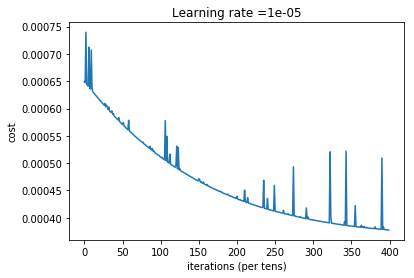

Parameters have been trained!


In [137]:
parameters = model(train_x, train_y)

# TODO: сравнивать с dev set error

In [138]:
# Tuning learning_rate and number of epochs:

# cost after 3100 epochs: 0.000573 (learning_rate 0.00001) - optimal
# Cost after 9900 epochs: 0.000422 (learning_rate 0.000025) - overfitting

In [139]:
def predict(X, parameters):
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    
    # only 2 parameters for now
    x = tf.placeholder("float", [2, None])
    z3 = forward_propagation(x, params)
    
    sess = tf.Session()
    predictions = sess.run(z3, feed_dict = {x: X})
    
    return predictions

In [140]:
# TODO: Model evaluation

# Calculate accuracy on the test set
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
# print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

# Calculate RMSE and R^2

# TODO:
# def evaluate_model(X_test, Y_test):

In [141]:
def predict_row(original_matrix, row_idx):
    return np.array(predict(np.atleast_2d([original_matrix[row_idx - 1, ], original_matrix[row_idx + 1, ]]),
                           parameters))

In [142]:
# Restoring Hi-C matrix with NN predictions
def restore_hic(original_matrix):
    predicted_matrix = np.copy(original_matrix)
    
    for i in range(1, original_matrix.shape[0] - 1):
        predicted_matrix[i, ] = predict_row(original_matrix, i)
        print(f"Row {i} is predicted")
    
    return predicted_matrix

Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted
Row 13 is predicted
Row 14 is predicted
Row 15 is predicted


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


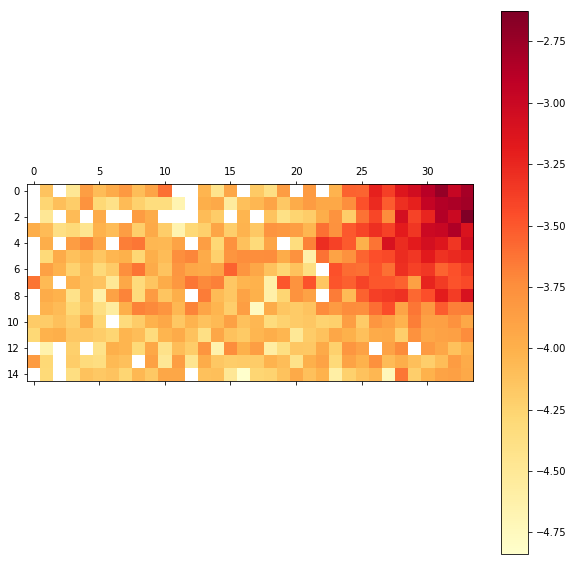

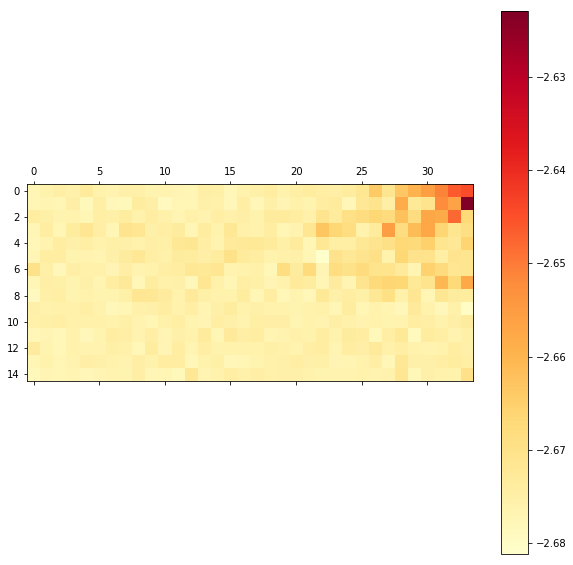

In [143]:
predicted_matrix = restore_hic(resulting_matrices[3])

# TODO: denormalize here to get right values

# Don't show top and bottom rows (we can't predict them yet)
plot_hic(resulting_matrices[3][1:-1, ])
plot_hic(predicted_matrix[1:-1, ])

Row 1 is predicted
Row 2 is predicted
Row 3 is predicted
Row 4 is predicted
Row 5 is predicted
Row 6 is predicted
Row 7 is predicted
Row 8 is predicted
Row 9 is predicted
Row 10 is predicted
Row 11 is predicted
Row 12 is predicted
Row 13 is predicted
Row 14 is predicted
Row 15 is predicted
Row 16 is predicted
Row 17 is predicted
Row 18 is predicted
Row 19 is predicted
Row 20 is predicted
Row 21 is predicted
Row 22 is predicted
Row 23 is predicted
Row 24 is predicted
Row 25 is predicted
Row 26 is predicted
Row 27 is predicted
Row 28 is predicted
Row 29 is predicted
Row 30 is predicted
Row 31 is predicted
Row 32 is predicted


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


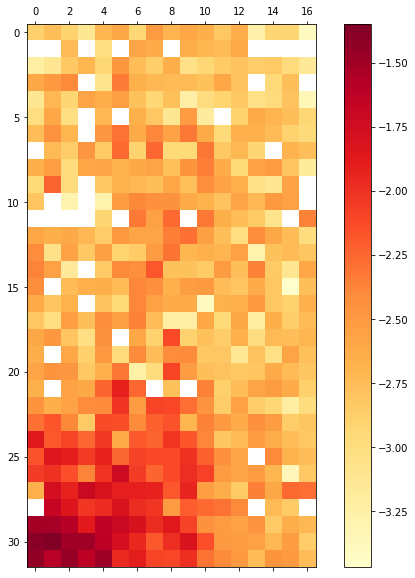

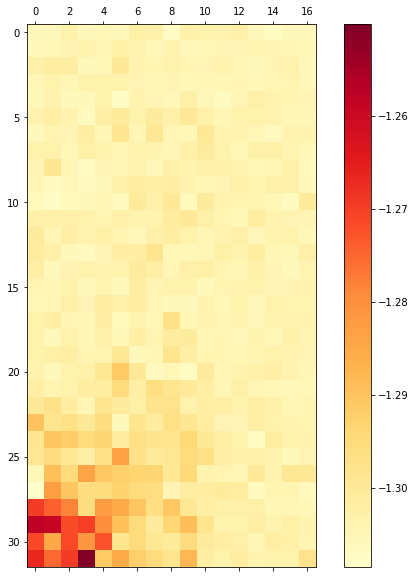

In [150]:
predicted_matrix = restore_hic(resulting_matrices[2])

# Don't show top and bottom rows (we can't predict them yet)
plot_hic(denormalize(resulting_matrices[2][1:-1, ], old_max, old_min))
plot_hic(denormalize(predicted_matrix[1:-1, ], old_max, old_min))